In [21]:
import time
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cpu


In [23]:
transform = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor(),
])


In [24]:
train_dataset = datasets.ImageFolder(root="train", transform=transform)
test_dataset = datasets.ImageFolder(root="test", transform=transform)

print(train_dataset.class_to_idx)
print(test_dataset.class_to_idx)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
Number of training samples: 148
Number of testing samples: 40


In [25]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [26]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
                
        self.conv_layer_1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.bn_1 = nn.BatchNorm2d(32)
        self.relu_1 = nn.ReLU()
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_layer_2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn_2 = nn.BatchNorm2d(64)
        self.relu_2 = nn.ReLU()
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc_1 = nn.Linear(16*16*64, 256)
        self.fc_1_relu = nn.ReLU()
        self.dropout_1 = nn.Dropout(0.2)

        self.fc_2 = nn.Linear(256, 128)
        self.fc_2_relu = nn.ReLU()
        self.dropout_2 = nn.Dropout(0.2)

        self.fc_3 = nn.Linear(128, 2)  

    def forward(self, x):
        out = self.conv_layer_1(x)
        out = self.bn_1(out)
        out = self.relu_1(out)
        out = self.max_pool_1(out)

        out = self.conv_layer_2(out)
        out = self.bn_2(out)
        out = self.relu_2(out)
        out = self.max_pool_2(out)

        out = out.reshape(out.size(0), -1)

        out = self.fc_1(out)
        out = self.fc_1_relu(out)
        out = self.dropout_1(out)

        out = self.fc_2(out)
        out = self.fc_2_relu(out)
        out = self.dropout_2(out)

        out = self.fc_3(out)
        return out

cnn_model = CNNModel().to(device)

In [27]:
error = nn.CrossEntropyLoss()
learning_rate = .01
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate, momentum=0.9)


In [28]:
total_epochs = 20  

loss_list = []      
iteration_list = [] 
count = 0            

num_of_iterations = len(train_loader) 

print("Starting training...")

training_start_time = time.time()

for epoch in range(total_epochs):
    cnn_model.train()  
    
    for i, (images, labels) in enumerate(train_loader):
       
        images = images.to(device)
        labels = labels.to(device)

       
        optimizer.zero_grad()

      
        outputs = cnn_model(images)

     
        loss = error(outputs, labels)

       
        loss.backward()

       
        optimizer.step()

        count += 1
        loss_list.append(loss.item())     
        iteration_list.append(count)      

       
        if (i + 1) % 10 == 0 or i == 0:
            print(f"Epoch [{epoch+1}/{total_epochs}], Step [{i+1}/{num_of_iterations}], Loss: {loss.item():.4f}")


Starting training...
Epoch [1/20], Step [1/5], Loss: 0.6920
Epoch [2/20], Step [1/5], Loss: 0.2416
Epoch [3/20], Step [1/5], Loss: 0.6424
Epoch [4/20], Step [1/5], Loss: 0.2431
Epoch [5/20], Step [1/5], Loss: 0.1540
Epoch [6/20], Step [1/5], Loss: 0.3385
Epoch [7/20], Step [1/5], Loss: 0.1729
Epoch [8/20], Step [1/5], Loss: 0.0832
Epoch [9/20], Step [1/5], Loss: 0.0418
Epoch [10/20], Step [1/5], Loss: 0.0681
Epoch [11/20], Step [1/5], Loss: 0.0240
Epoch [12/20], Step [1/5], Loss: 0.0045
Epoch [13/20], Step [1/5], Loss: 0.0163
Epoch [14/20], Step [1/5], Loss: 0.0057
Epoch [15/20], Step [1/5], Loss: 0.0105
Epoch [16/20], Step [1/5], Loss: 0.0075
Epoch [17/20], Step [1/5], Loss: 0.0035
Epoch [18/20], Step [1/5], Loss: 0.0012
Epoch [19/20], Step [1/5], Loss: 0.0012
Epoch [20/20], Step [1/5], Loss: 0.0001


In [29]:
training_end_time = time.time()
print(f"\nTotal training time: {training_end_time - training_start_time} seconds")


Total training time: 172.9618480205536 seconds


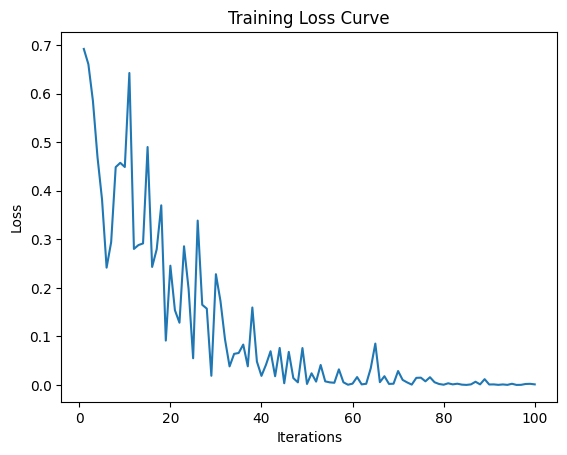

In [30]:
plt.plot(iteration_list, loss_list)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

In [31]:
cnn_model.eval()  

total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)

        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples * 100
print(f"Test Accuracy: {accuracy:.2f}%")

test_iter = iter(test_loader)
images, labels = next(test_iter)
images = images.to(device)
labels = labels.to(device)
outputs = cnn_model(images)
_, preds = torch.max(outputs, 1)

plt.show()

Test Accuracy: 100.00%
